# Importing and exploring pxp files with simultaneously recorded wave data
## A first exploration
#### Marco Arieli Herrera-Valdez, Ana Itzel Aquiles-Reyes
#### Facultad de Ciencias, Universidad Nacional Autónoma de México

Data contained in .pxp files is extracted using a python module called _igor.py_ (https://github.com/wking/igor). The data is filtered to remove noise and graphed for superficial exploration.
All the auxiliary files necessary to run the code below can be found in _transientPreAnalysis.py_
All the data files are assumed to be in the local directory called _hipophysis_.

In [44]:
from transientPreAnalysis import * 
%matplotlib inline 

### Extraction a data set

First let us build a list of the files with _.pxp_ extensions and prefixed as _Fmin_

In [37]:
dirName="./hipophysis/"
pxpFiles=getFileList(dataDir=dirName, prefix="Fmin", suffix=".pxp",includeDataDir=1)

Found 6 files with the indicated string
['./hipophysis/FminBasalEndocrinas.pxp', './hipophysis/FminBasalPericitos.pxp', './hipophysis/FminGnRHEndocrinas.pxp', './hipophysis/FminGnRHPericitos.pxp', './hipophysis/FminTRHEndocrinas.pxp', './hipophysis/FminTRHPericitos.pxp']


Now choose one of the files from the list and get the data in it.

In [38]:
# Read the data from one file
fName = pxpFiles[3]
fMinData,sampTimes=extractDebleachedFminData(fName)
# Calculate all the areas under the curves before normalization
areas=fMinData.cumsum(1)[:,-1]
# Look for cells that may have faulty data 
goodCells=sc.where(sc.isnan(areas)==False)[0]
# Keep the good data
fMinData=fMinData[goodCells]
# Count cells and frames
nCells,nFrames= fMinData.shape

Get all the signals and smooth them

In [39]:
hiFreqCut=40
# Smooth the signals
smoothCa= sc.zeros(fMinData.shape)
for n in sc.arange(nCells):
	dd=fMinData[n]; 
	smoothCa[n]=lowHighCutFreqSmoothing(dd, lowCut=0, hiCut=hiFreqCut)

Plot all the data for check

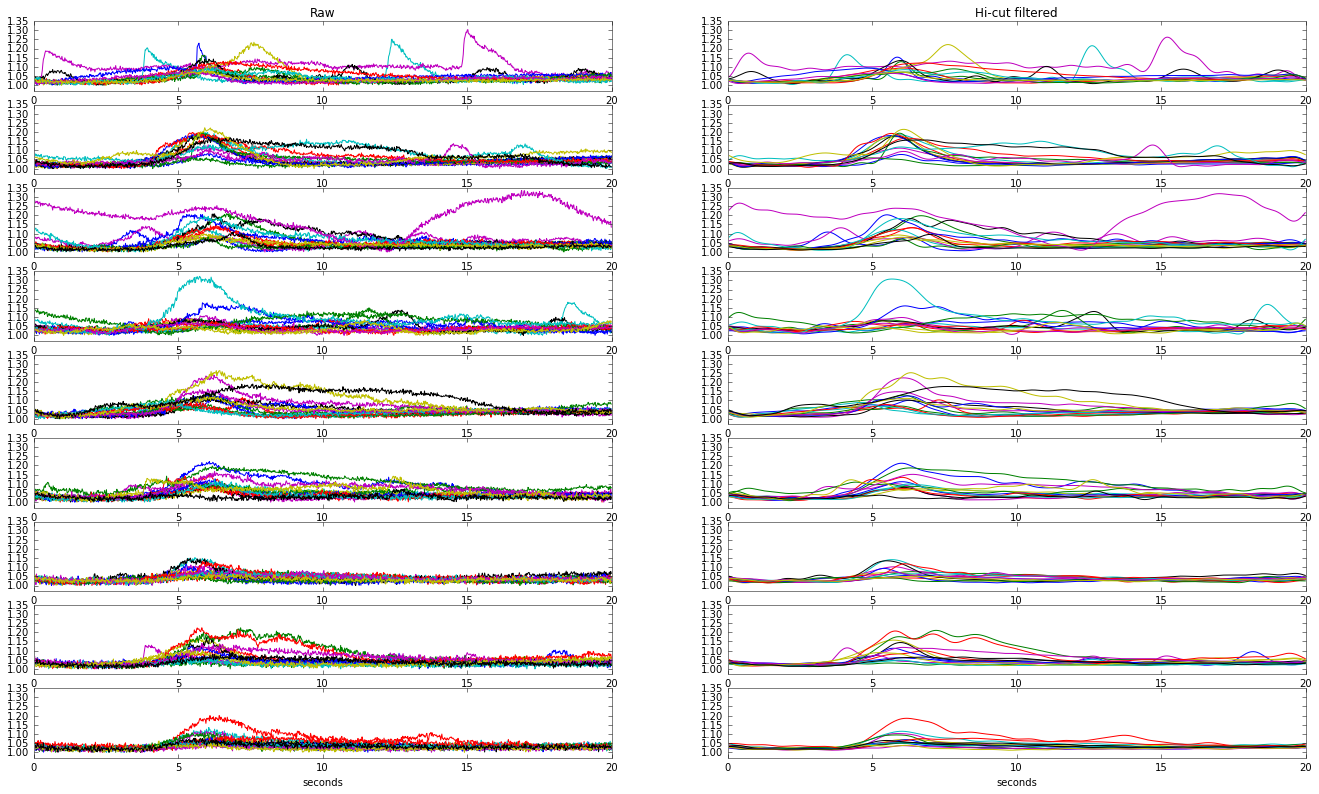

In [46]:
nPieces=9; q= nCells/nPieces
fig= gr.figure(figsize=(19, 11));
fig.canvas.set_window_title("%s"%(fName))
gr.ioff(); r=nPieces; c=2; 
ax1=list(); ax2=list()
for m in sc.arange(nPieces):
	ax1.append(fig.add_subplot(r,c,m*c +1))
	ax2.append(fig.add_subplot(r,c,m*c +2))
ax1[0].set_title("Raw")
ax2[0].set_title("Hi-cut filtered")
for m in sc.arange(nPieces):
	a= sc.int32(m * q)
	b= sc.int32(sc.minimum(((m+1) * q), nCells))
	dd = fMinData[a:b]
	ff = smoothCa[a:b]
	for n in sc.arange(len(dd)):
		ax1[m].plot(sampTimes, dd[n])
		ax2[m].plot(sampTimes, ff[n])
	ax1[m].set_ylim(fMinData.min()*0.97, fMinData.max()*1.01)
	ax2[m].set_ylim(fMinData.min()*0.97, fMinData.max()*1.01)
ax1[m].set_xlabel("seconds")
ax2[m].set_xlabel("seconds")
fig.subplots_adjust(left=0.05, right=0.98, top=0.98, bottom=0.05)
gr.ion(); gr.draw()


### Auxiliary functions 

All the functions defined below can be found in the library file _transientPreAnalysis.py_

Function to look for files with specific prefix and suffix in a given directory

In [41]:
def getFileList(dataDir, prefix, suffix, includeDataDir=1):
    """
    getFileList look for files with specific prefix and suffix within the directory dataDir
    Example:
    files=getFileList(dataDir, prefix, suffix)
    """
    files=list()
    for f in os.listdir(dataDir):
        a= sc.int32(os.path.isfile(os.path.join(dataDir,f)))
        b= sc.int32(str.find(f,prefix)>-1)
        c= sc.int32(str.find(f,suffix)>0)
        #print(a,b,c)
        if (a*b*c):
            if includeDataDir:
                files.append(dataDir+f)
            else:
                files.append(f)
    nFiles = len(files)
    print("Found %d files with the indicated string"%nFiles)
    print(files)
    return files

Define a function to open the pxp files and get the data from them

In [42]:
def extractDebleachedFminData(filePath):
    allData= igor.load(filePath)
    #dataNames= st.digits.split(allData.children[0].userstr["S_waveNames"], ";")[:-1]
    bbb=allData.children[0].userstr[b"S_waveNames"]
    aaa=bbb.decode("UTF-8")
    dataNames= aaa.split(";")[:-1]
    waves= list()
    for m in sc.arange(len(dataNames)):
        waveNum=sc.int32(dataNames[m][1+str.rfind(dataNames[0],"e"):])
        str1= "waves.append(allData."+dataNames[m] + "_%dF_min.data)"%(waveNum-1)
        #print(dataNames[m],str1)
        exec(str1)
    return sc.array(waves), sc.array(allData.sec.data)

Filter out high frequency noise

In [43]:
def lowHighCutFreqSmoothing(x,lowCut=400,hiCut=600):
    """
    Cut low and high frequency oscilations from a signal x. Example:
    lowHighCutFreqSmoothing(x,lowCut=400,hiCut=600)
    """
    rft= fftpack.rfft(x); 
    rft[:lowCut]=0; 
    rft[hiCut:]=0; 
    y=fftpack.irfft(rft); 
    return y 